# Ungraded Lab: Using more sophisticated images with Convolutional Neural Networks

## Inspect the Dataset


In [1]:
import os
import random
import numpy as np
from io import BytesIO

# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

# Interactive widgets
from ipywidgets import widgets

2025-04-02 13:40:40.711093: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 13:40:40.713443: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 13:40:40.757097: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 13:40:40.758021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-02 13:40:41.706436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-04-02 13:40:42.771481: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-04-02 13:40:42.771515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: ange-pc
2025-04-02 13:40:42.771520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: ange-pc
2025-04-02 13:40:42.771625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.120.0
2025-04-02 13:40:42.771641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.120.0
2025-04-02 13:40:42.771646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.120.0


In [3]:
BASE_DIR = '../../datasets/cats_and_dogs_filtered'

train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


print(f"Contents of base directory: {os.listdir(BASE_DIR)}")
print(f"Contents of train directory: {train_dir}")
print(f"Contents of validation directory: {validation_dir}")

Contents of base directory: ['train', 'validation', 'vectorize.py']
Contents of train directory: ../../datasets/cats_and_dogs_filtered/train
Contents of validation directory: ../../datasets/cats_and_dogs_filtered/validation


In [4]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(f"5 files in cats subdir: {train_cat_fnames[:5]}")
print(f"5 files in dogs subdir: {train_dog_fnames[:5]}")

5 files in cats subdir: ['cat.997.jpg', 'cat.9.jpg', 'cat.223.jpg', 'cat.467.jpg', 'cat.185.jpg']
5 files in dogs subdir: ['dog.113.jpg', 'dog.406.jpg', 'dog.343.jpg', 'dog.203.jpg', 'dog.767.jpg']


In [5]:
# Check the total number of cat and dog images in the `train` and `validation` directories:
print(f'total training cat images: {len(os.listdir(train_cats_dir))}')
print(f'total training dog images: {len(os.listdir(train_dogs_dir))}')

print(f'total validation cat images: {len(os.listdir(validation_cats_dir))}')
print(f'total validation dog images: {len(os.listdir(validation_dogs_dir))}')

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


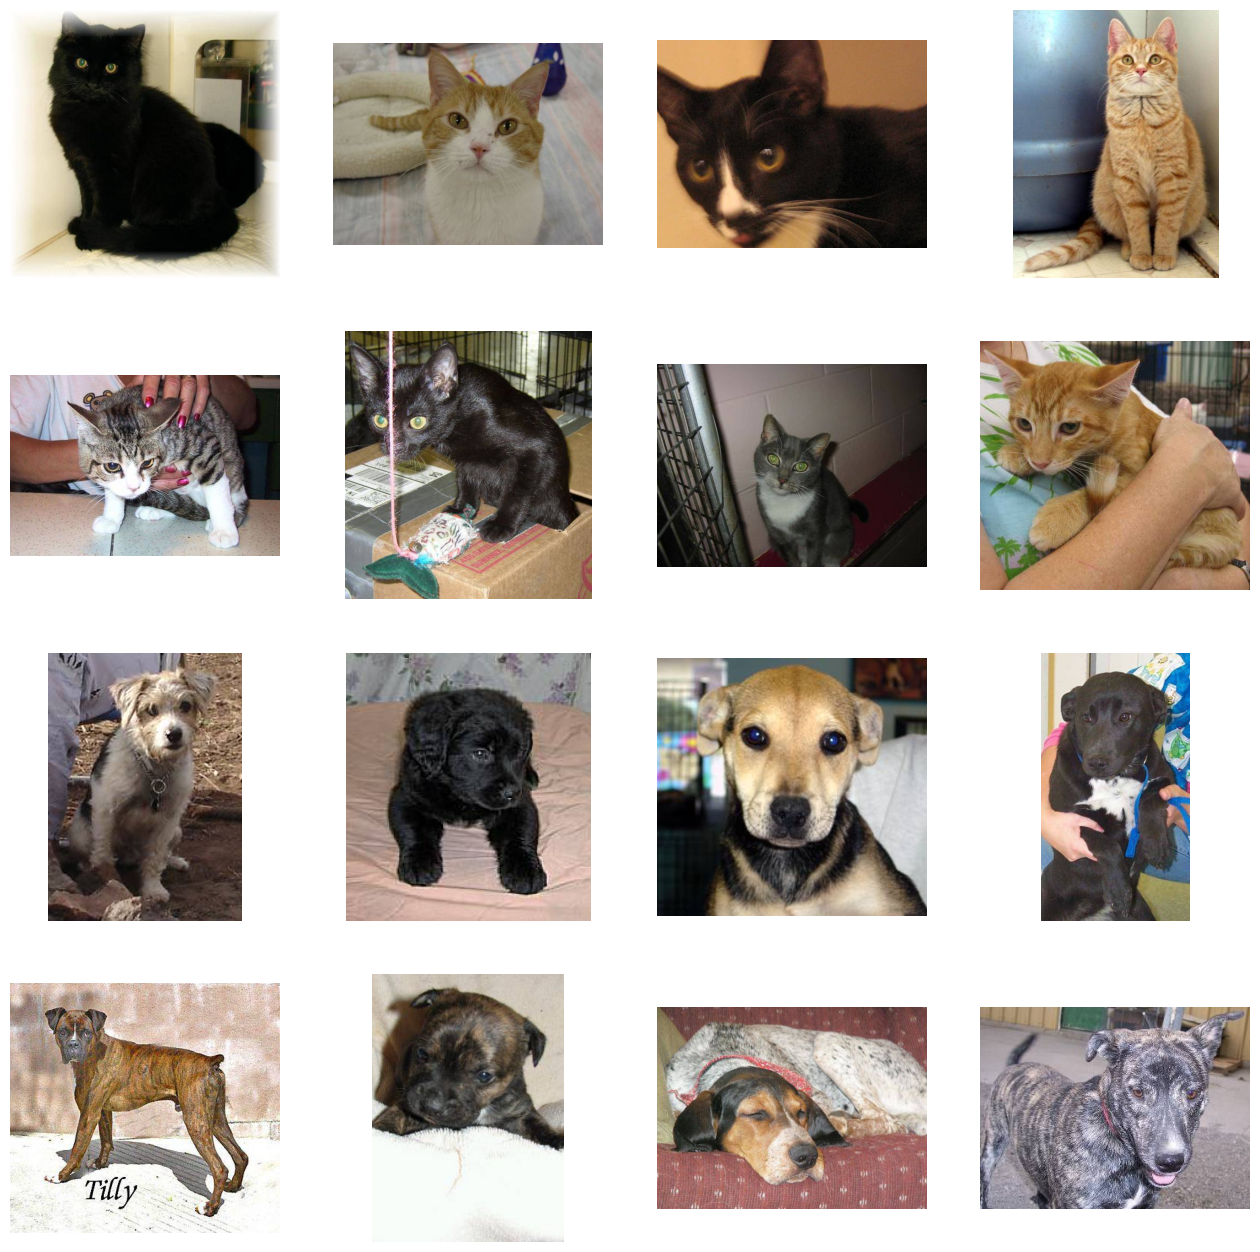

In [6]:
# Parameters for your graph; you will output images in a 4x4 configuration
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in random.sample(train_cat_fnames, k=8)]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in random.sample(train_dog_fnames, k=8)]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Building a Small Model from Scratch

### Compile the Model

In [7]:
def create_model():
    '''Creates a CNN with 4 convolutional layers'''
    model = tf.keras.models.Sequential([
        # Rescale the image. Note the input shape is the desired size of the image: 150x150 with 3 bytes for color
        tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.Rescaling(1./255),
        # Convolution and Pooling layers
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('cats') and 1 for the other ('dogs')
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model


model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       7

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy']
)

### Data Preprocessing


In [9]:
# Instantiate the Dataset object for the training set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
)

# Instantiate the Dataset object for the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [10]:
SHUFFLE_BUFFER_SIZE = 1000                # 
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE   # dynamically determine the optimal number of elements (batches in this context) to prefetch at runtime

train_dataset_final = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
validation_dataset_final = validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

### Training

In [11]:
# Callbacks
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.80:
            print("\nReached 95% accuracy and 80% val_accuracy so cancelling training!")
            # self.model.stop_training = True

You will now train on all 2,000 images available, for 15 epochs, and monitor the accuracy as well on the 1,000 images in the validation set.

Do note the values per epoch. You'll see 4 -- Loss, Accuracy, Validation Loss and Validation Accuracy.

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `accuracy`, on the other hand, is the portion of correct guesses.


In [12]:
history = model.fit(
    train_dataset_final,
    epochs=15,
    validation_data=validation_dataset_final,
    verbose=2,
    callbacks=[CustomCallback()]
)

Epoch 1/15
100/100 - 15s - loss: 0.7473 - accuracy: 0.5215 - val_loss: 0.6935 - val_accuracy: 0.5000 - 15s/epoch - 155ms/step
Epoch 2/15
100/100 - 14s - loss: 0.6971 - accuracy: 0.5205 - val_loss: 0.6916 - val_accuracy: 0.5320 - 14s/epoch - 143ms/step
Epoch 3/15
100/100 - 14s - loss: 0.6864 - accuracy: 0.5615 - val_loss: 0.6547 - val_accuracy: 0.6350 - 14s/epoch - 142ms/step
Epoch 4/15
100/100 - 13s - loss: 0.6593 - accuracy: 0.6205 - val_loss: 0.6336 - val_accuracy: 0.6470 - 13s/epoch - 135ms/step
Epoch 5/15
100/100 - 14s - loss: 0.6363 - accuracy: 0.6435 - val_loss: 0.6105 - val_accuracy: 0.6750 - 14s/epoch - 135ms/step
Epoch 6/15
100/100 - 13s - loss: 0.5890 - accuracy: 0.7020 - val_loss: 0.5922 - val_accuracy: 0.6930 - 13s/epoch - 134ms/step
Epoch 7/15
100/100 - 14s - loss: 0.5474 - accuracy: 0.7265 - val_loss: 0.6168 - val_accuracy: 0.6770 - 14s/epoch - 136ms/step
Epoch 8/15
100/100 - 13s - loss: 0.5040 - accuracy: 0.7555 - val_loss: 0.5745 - val_accuracy: 0.6890 - 13s/epoch - 135

### Model Prediction


In [13]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a dog")
        else:
            print(filename + " is a cat")


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

### Visualizing Intermediate Representations

To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 [==============================] - 0s 128ms/step


/tmp/ipykernel_666597/149368221.py:41: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
/tmp/ipykernel_666597/149368221.py:44: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


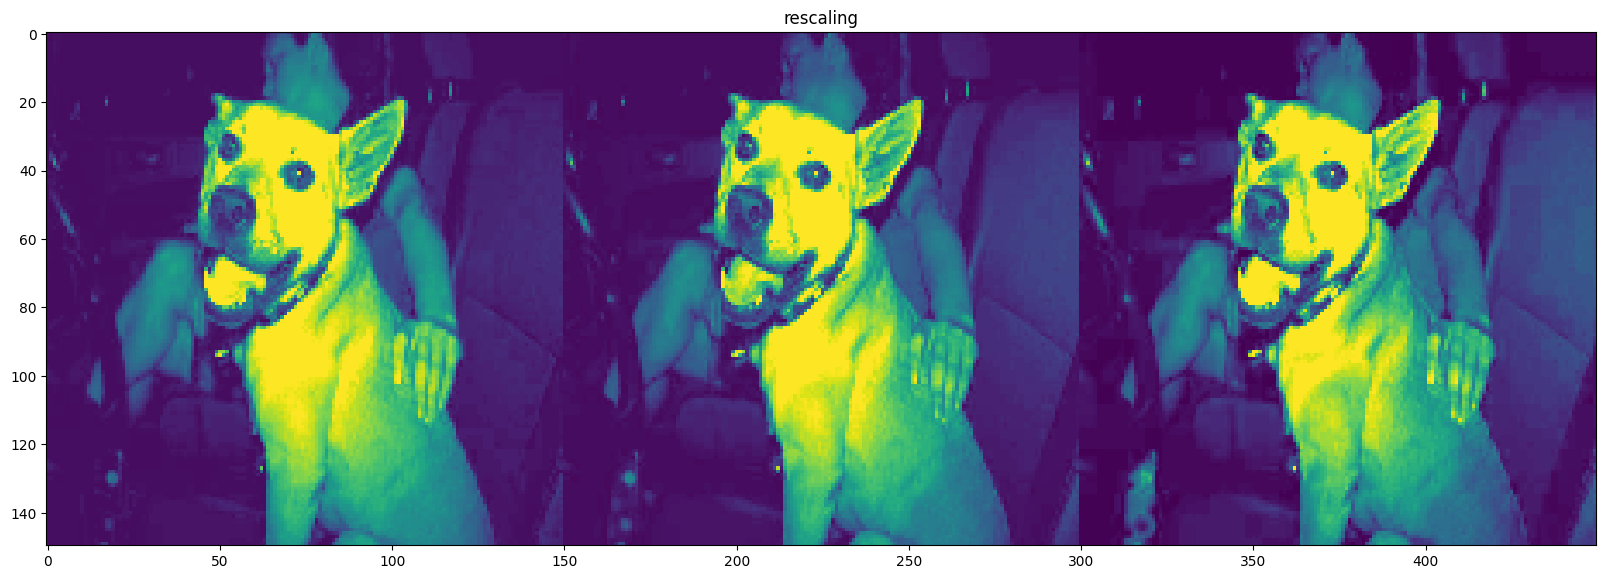

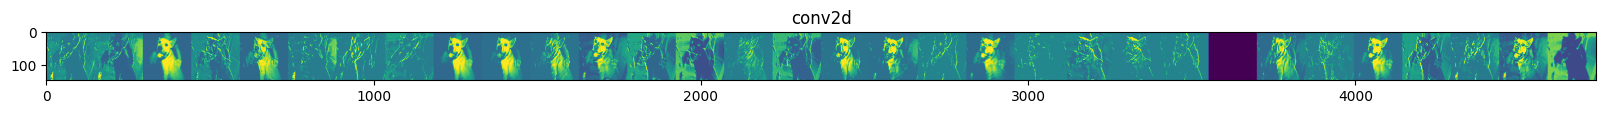

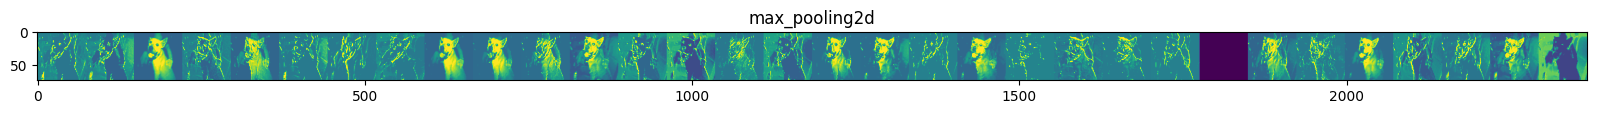

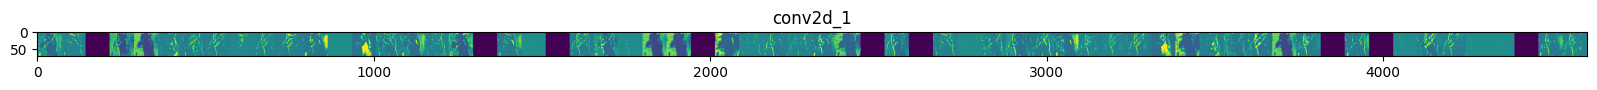

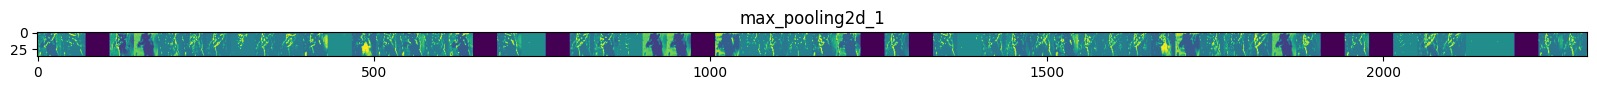

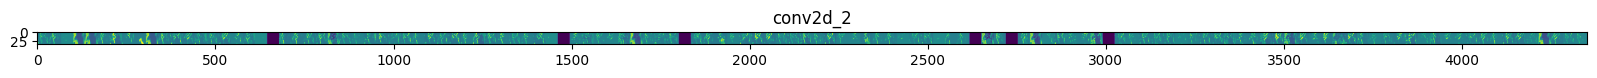

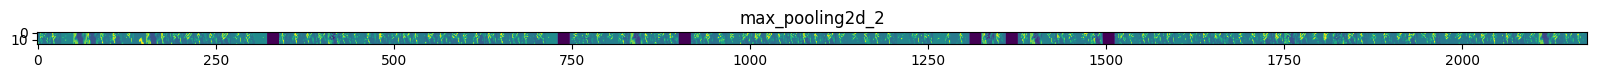

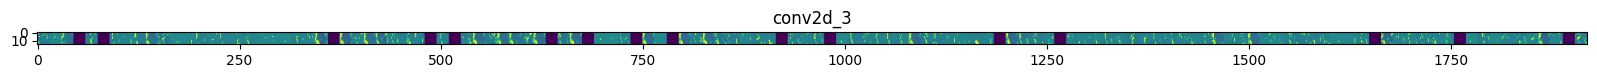

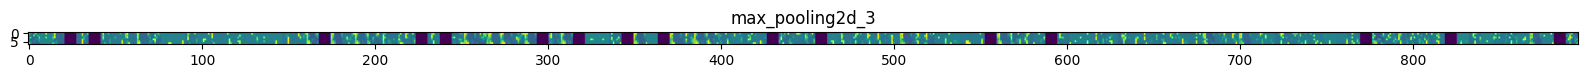

In [14]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = tf.keras.utils.load_img(img_path, target_size=(150, 150))     # this is a PIL image
x = tf.keras.utils.img_to_array(img)                                # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)                                       # Numpy array with shape (1, 150, 150, 3)

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[1]         # feature map shape (1, size, size, n_features)

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid.

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a CNN (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

### Evaluating Accuracy and Loss for the Model

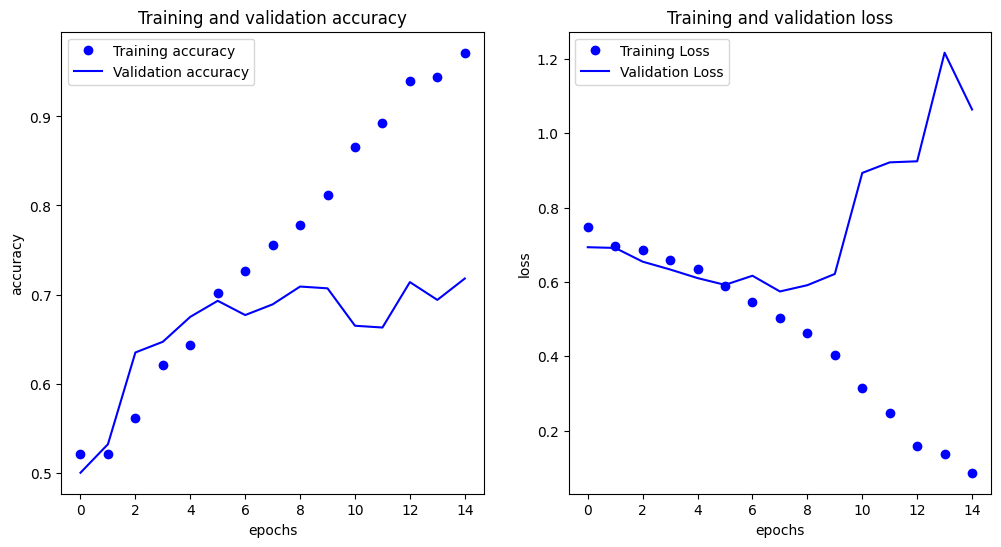

In [15]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)

As you can see, the model is **overfitting** like it's getting out of fashion. The training accuracy (in blue) gets close to 100% while the validation accuracy (solid line) stalls at 70%. The validation loss reaches its minimum after only five epochs.

Since you have a relatively small number of training examples (2000), overfitting should be the number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that you are fitting the parameters of our model to a given dataset, how can you make sure that the representations learned by the model will be applicable to data it has never seen before? How do you avoid learning things that are specific to the training data?

In the next exercise, you'll look at ways to prevent overfitting in this classification model.

## Data augmentation

One simple method to avoid overfitting is to augment the images. If you think about it, most pictures of a cat are very similar -- the ears are at the top, the eyes are below the ears etc. Things like the distance between the eyes and ears will always be quite similar too.

What if you tweak with the images a bit -- rotate the image, squash it, etc.  That's what image augementation is all about.

To do that, you will build a data augmentation model with [preprocessing layers for image augmentation](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation). This will transform the data during training to introduce variations of the same image. Let's quickly go over the layers you will use in this exercise.

* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) is for randomly flipping the images horizontally, vertically, or both.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) rotates the image by an angle within a given range.
* [RandomTranslation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation) shifts pictures vertically and horizontally.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) zooms into or out of the images.

In addition, some of these layers have a `fill_mode` parameter. This is the strategy used for filling newly created pixels, which can appear after a rotation or a width/height shift.

The code below will create this model with some set parameters. After you complete this lab, feel free to modify these and see the impact on the results.

In [16]:
# Define fill mode.
FILL_MODE = 'nearest'

# Create the augmentation model.
data_augmentation = tf.keras.Sequential([
  # Specify the input shape.
  tf.keras.Input(shape=(150,150,3)),
  # Add the augmentation layers
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
  tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode=FILL_MODE),
  tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
])

In [17]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(num_aug):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, num_aug + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

In [18]:
# Get a batch of images
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 20


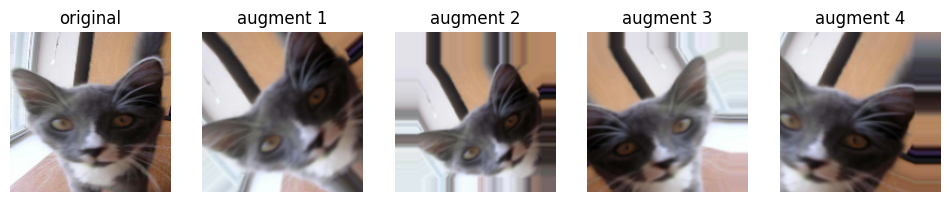

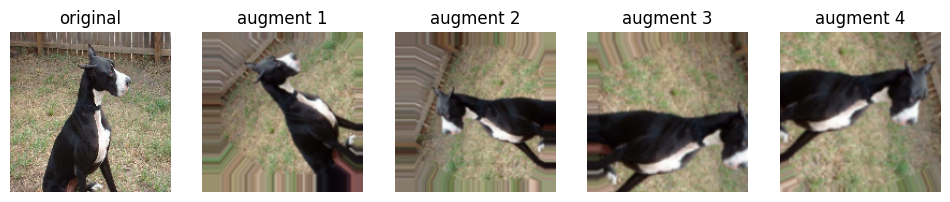

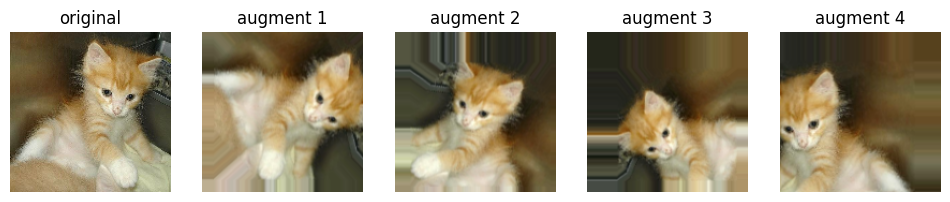

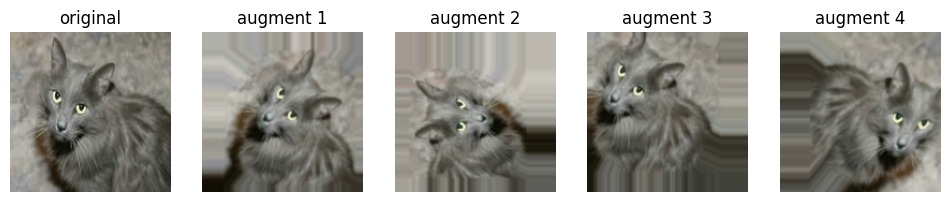

In [19]:
NUM_AUG = 4

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# Uncomment the line below to delete the variable to free up some memory
# del sample_batch

Now that you see what the preprocessing layers do, you can prepend these to the base model so it can generate transformed images to the base model. Do note that these layers are only active while training. They are automatically disabled during prediction and evaluation.

In [20]:
# Instantiate the base model
model_without_aug = create_model()

# Prepend the data augmentation layers to the base model
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug
])

# Compile the model
model_with_aug.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

In [21]:
EPOCHS=80

# Train the new model
history_with_aug = model_with_aug.fit(
  train_dataset_final,
  epochs=EPOCHS,
  validation_data=validation_dataset_final,
  verbose=2,
  callbacks=[CustomCallback()])

Epoch 1/80
100/100 - 17s - loss: 0.6934 - accuracy: 0.5355 - val_loss: 0.6897 - val_accuracy: 0.5010 - 17s/epoch - 174ms/step
Epoch 2/80
100/100 - 15s - loss: 0.6908 - accuracy: 0.5215 - val_loss: 0.6968 - val_accuracy: 0.5000 - 15s/epoch - 153ms/step
Epoch 3/80
100/100 - 15s - loss: 0.6841 - accuracy: 0.5545 - val_loss: 0.6690 - val_accuracy: 0.6040 - 15s/epoch - 150ms/step
Epoch 4/80
100/100 - 15s - loss: 0.6809 - accuracy: 0.5620 - val_loss: 0.7072 - val_accuracy: 0.5020 - 15s/epoch - 149ms/step
Epoch 5/80
100/100 - 15s - loss: 0.6740 - accuracy: 0.5825 - val_loss: 0.6594 - val_accuracy: 0.6200 - 15s/epoch - 149ms/step
Epoch 6/80
100/100 - 15s - loss: 0.6668 - accuracy: 0.5960 - val_loss: 0.6419 - val_accuracy: 0.6450 - 15s/epoch - 148ms/step
Epoch 7/80
100/100 - 15s - loss: 0.6623 - accuracy: 0.5975 - val_loss: 0.6298 - val_accuracy: 0.6510 - 15s/epoch - 148ms/step
Epoch 8/80
100/100 - 15s - loss: 0.6440 - accuracy: 0.6385 - val_loss: 0.6267 - val_accuracy: 0.6290 - 15s/epoch - 148

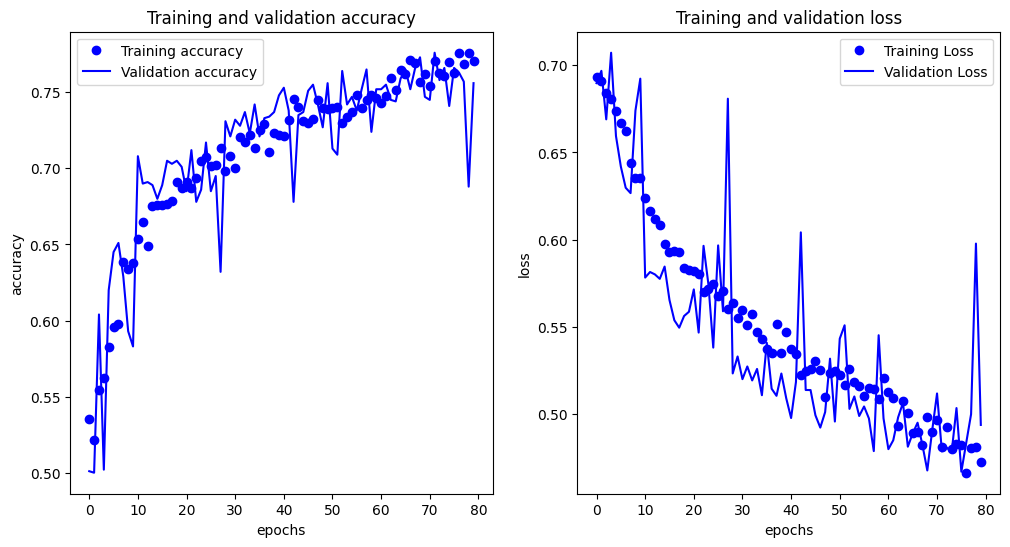

In [23]:
# Plot the results of training with data augmentation
plot_loss_acc(history_with_aug)

In [ ]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets():
    """Creates datasets for training and validation.

    Returns:
        (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """

    ### START CODE HERE ###

    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=DATA_DIR,
        image_size= (120, 120),
        batch_size=128,
        label_mode='binary',
        validation_split=.15,
        subset='both',
        seed=42 
    )

    ### END CODE HERE ###

    return training_dataset, validation_dataset

In [ ]:
# GRADED FUNCTION: create_augmentation_model
def create_augmentation_model():
    """Creates a model (layers stacked on top of each other) for augmenting images of cats and dogs.

    Returns:
        tf.keras.Model: The model made up of the layers that will be used to augment the images of cats and dogs.
    """

    ### START CODE HERE ###
    
    augmentation_model = tf.keras.Sequential([ 
		tf.keras.layers.Input(input_size= (120, 120, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
    ]) 
    
    ### END CODE HERE ###

    return augmentation_model

In [ ]:
# GRADED FUNCTION: create_model

def create_model():
    """Creates the untrained model for classifying cats and dogs.

    Returns:
        tf.keras.Model: The model that will be trained to classify cats and dogs.
    """

    ### START CODE HERE ###

	# Get the augmentation layers (or model) from your earlier function
    augmentation_layers = create_augmentation_model()

	# Don't forget to add the augmentation layers! These usually go right after the Input!
    model = tf.keras.models.Sequential([ 
        augmentation_layers,
        
        tf.keras.Input(shape=(120, 120, 3)),
        tf.keras.layers.Rescaling(1./255),
        # Convolution and Pooling layers
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('cats') and 1 for the other ('dogs')
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 

  
    model.compile( 
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics = ['accuracy']
    ) 
    
    ### END CODE HERE ###

    return model

In [ ]:
# GRADED CLASS: EarlyStoppingCallback

### START CODE HERE ###

# Remember to inherit from the correct class
class EarlyStoppingCallback():
    # Define the correct function signature for on_epoch_end method
    def on_epoch_end():
        # Check if the accuracy is greater or equal to 0.8 and validation accuracy is greater or equal to 0.8
        # if None >= None and None >= None:
        if logs.get('accuracy') >= 0.80 and logs.get('val_accuracy') >= 0.80:
            self.model.stop_training = True

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

### END CODE HERE ###